In [6]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

In [22]:
gdf_est = aqiGDL.gdf_from_db('estaciones_gdl','Estaciones')
gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:4485')
gdf_est.head(2)

,Name,x,y,geometry
0,10. Colon,-103.400806,20.606105,POINT (1293591.024 2297153.040)
1,11. UVM,-103.406642,20.608323,POINT (1292967.179 2297371.375)


In [21]:
gdf_air = gpd.read_file('../data/processed/PM10_2018-12-20_23h_hour.geojson')
gdf_air = ox.project_gdf(gdf_air,to_crs='EPSG:4485')
gdf_air.head(2)

,lat,long,conc,geometry
0,20.529149,-103.455437,216.763139,POINT (1288259.609 2288312.311)
1,20.539149,-103.455437,213.181621,POINT (1288207.853 2289426.289)


In [20]:
G = aqiGDL.graph_from_db('Guadalajara')
edges = ox.graph_to_gdfs(G,nodes=False)
edges = ox.project_gdf(edges,to_crs='EPSG:4485')
#G = None
edges.head(2)

,highway,oneway,length,geometry,name,lanes,bridge,access,junction,maxspeed,ref,service,tunnel,width,area,u,v,key
0,residential,False,122.459,"LINESTRING (1307191.566 2301460.295, 1307205.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6347554817,6347554813,0
1,residential,False,144.322,"LINESTRING (1307191.566 2301460.295, 1307174.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6347554817,1643880278,0


(2288312.311495612, 2312651.581859525)

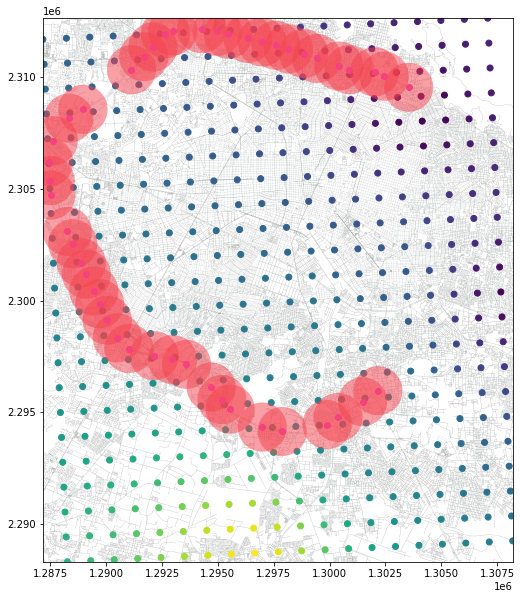

In [48]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
edges.plot(ax=ax, color='#929494', zorder=0, linewidth=0.1)
gdf_air.plot(ax=ax, column='conc', zorder=1)
gdf_est.plot(ax=ax, zorder=3, color='#f5427e')
gdf_est.buffer(1100).plot(ax=ax, zorder=2, color='#f5424e', alpha=0.5)

minx, miny, maxx, maxy = gdf_air.geometry.total_bounds

ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)

In [106]:
buffer_dist = 1000
buffer = gpd.GeoDataFrame({'geometry':gdf_est.buffer(buffer_dist),'Name':gdf_est['Name']},geometry='geometry',crs=gdf_est.crs)
buffer['mean-conc'] = gpd.sjoin(buffer,gdf_air).groupby(['Name']).mean().reset_index()['conc']

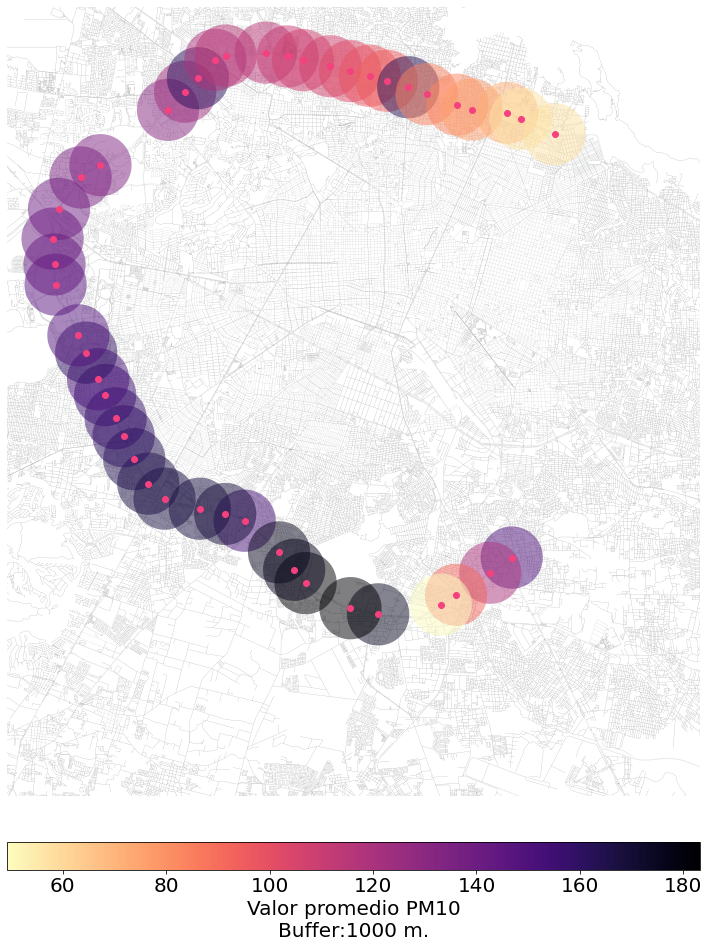

In [109]:
fig, axes = plt.subplots(2,1,figsize=(10,14), gridspec_kw={"height_ratios":[0.96, 0.03]})
ax = axes[0]
edges.plot(ax=ax, color='#929494', zorder=0, linewidth=0.1)
#gdf_air.plot(ax=ax, column='conc', zorder=1)
gdf_est.plot(ax=ax, zorder=3, color='#f5427e')
buffer.plot(ax=ax, zorder=2,  column='mean-conc', markersize=buffer_dist, alpha=0.5, cax=axes[1],legend=True, 
            cmap='magma_r', legend_kwds={'label': "Valor promedio en zona de captura",'orientation': "horizontal"})

minx, miny, maxx, maxy = gdf_air.geometry.total_bounds
ax.set_xlim(minx-1200,maxx)
ax.set_ylim(miny,maxy+1000)
ax.axis('off')
axes[1].set_xlabel(f'Valor promedio PM10\nBuffer:{buffer_dist} m.',fontsize=20)
axes[1].tick_params(labelsize=20)
fig.tight_layout()
for f in ['pdf','png']:
    plt.savefig(f'../output/figures/GDL-estaciones-pm10-test.{f}',dpi=300,transparent=False, bbox_inches = 'tight')